# Evaluate likelihood ratio and posterior

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import roc_curve

from simulation.population_sim import SubhaloSimulator
from inference.estimator import ParameterizedRatioEstimator
from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Evaluate model on train and test data

In [2]:
x_train = np.load("../data/samples/x_train.npy", mmap_mode="c")
y_train = np.load("../data/samples/y_train.npy")
theta_train = np.load("../data/samples/theta_train.npy")

x_test = np.load("../data/samples/x_test.npz")

In [3]:
x_train = x_train[:1000]
y_train = y_train[:1000]
theta_train = theta_train[:1000]

x_train = np.array(x_train)

## ROC curve

In [16]:
def make_roc_curves(name):
    re = ParameterizedRatioEstimator(
        resolution=64,
        n_parameters=2,
    )
    re.load("../data/models/" + name)
    
    llr_train, _ = re.log_likelihood_ratio(x=x_train, theta=theta_train, test_all_combinations=False)
    s_train = s_from_r(np.exp(llr_train))
    
    fpr_train, tpr_train, _ = roc_curve(y_train, s_train)
    
    return fpr_train, tpr_train, llr_train

In [17]:
fpr_train_alice, tpr_train_alice, llr_train_alice = make_roc_curves("alice")
fpr_train_carl, tpr_train_carl, llr_train_carl = make_roc_curves("debug")

In [18]:
llr_train_carl

array([ -4938.8467,  -2990.7483,  -2941.6902,  -2998.3623,  -3036.3655,
        -3067.0515,  -2963.1545,  -2967.0476, -13777.725 ,  -2939.9202,
        -2955.4143,  -3914.5837,  -5654.8257,  -3220.5789,  -3189.3274,
        -3044.383 ,  -3294.9358,  -4438.9966,  -2938.5505,  -2929.2795,
       -10689.608 ,  -5178.135 ,  -2960.7063,  -4472.443 ,  -3014.8752,
        -2933.8484,  -9858.828 ,  -3342.3252,  -3010.927 ,  -2938.4812,
        -2963.1575,  -5262.033 ,  -2963.9497,  -5749.6743,  -2963.0857,
        -7202.3926,  -7856.518 ,  -2963.2778,  -2962.291 ,  -8706.069 ,
        -2962.9548,  -2961.304 ,  -2957.543 ,  -3229.3494,  -2944.832 ,
        -8740.236 ,  -2943.4822,  -3779.78  ,  -2959.1418,  -4822.293 ,
        -3039.1409,  -3219.408 ,  -2961.4543,  -6334.4775,  -2996.616 ,
        -5773.537 , -12335.815 ,  -3021.2458,  -2961.4382,  -8680.076 ,
        -4939.7563,  -3015.589 ,  -9523.764 ,  -2935.5452,  -2939.9324,
        -2963.19  ,  -2989.931 ,  -2944.9143,  -2937.284 ,  -856

In [19]:
llr_train_alice

array([ 16040.25  ,   9991.498 ,   9951.266 ,  10242.545 ,  10167.501 ,
        10599.718 ,  10081.22  ,  10081.867 ,  47431.426 ,   9892.852 ,
         9980.119 ,  12220.727 ,  18301.217 ,  10902.143 ,  10400.92  ,
        10041.357 ,  11126.98  ,  14182.893 ,   9883.58  ,   9930.233 ,
        36799.812 ,  15424.616 ,  10075.344 ,  13874.123 ,   9893.891 ,
         9856.873 ,  37468.64  ,  11336.886 ,  10033.303 ,   9916.809 ,
        10081.84  ,  18527.432 ,   9900.458 ,  21293.24  ,  10081.623 ,
        25694.822 ,  26176.193 ,  10081.435 ,  10076.596 ,  29117.502 ,
        10078.255 ,   9849.713 ,  10051.263 ,  11217.131 ,   9855.933 ,
        29541.854 ,   9936.682 ,  13723.533 ,  10063.492 ,  14714.0625,
         9992.753 ,  11372.418 ,   9867.341 ,  21944.676 ,   9983.65  ,
        19336.883 ,  43111.895 ,  10004.729 ,   9801.494 ,  29655.092 ,
        15851.162 ,  10079.209 ,  33290.375 ,   9913.431 ,   9932.855 ,
        10081.863 ,   9851.238 ,   9969.355 ,   9906.092 ,  2989

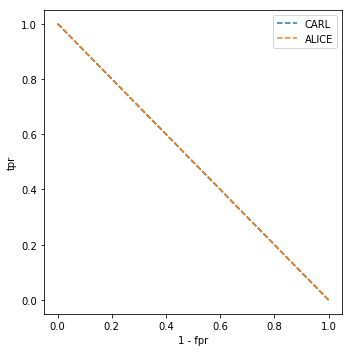

In [6]:
fig = plt.figure(figsize=(5,5))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
plt.plot(1. - fpr_train_carl, tpr_train_carl, c="C0", ls="--", label="CARL")
plt.plot(1. - fpr_train_alice, tpr_train_alice, c="C1", ls="--", label="ALICE")

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")

plt.tight_layout()
plt.show()


## Evaluate on grid

In [20]:
grid_res = 25

alpha_test = np.linspace(0., 20., grid_res)
beta_test = np.linspace(-1., -3., grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

In [27]:
theta_grid

array([[ 0.        , -1.        ],
       [ 0.83333333, -1.        ],
       [ 1.66666667, -1.        ],
       ...,
       [18.33333333, -3.        ],
       [19.16666667, -3.        ],
       [20.        , -3.        ]])

In [24]:
re = ParameterizedRatioEstimator(
    resolution=64,
    n_parameters=2,
)
re.load("../data/models/debug")

nllr, _ = re.log_likelihood_ratio(x=x_train[:20], theta=theta_grid)
nllr = -2. * nllr

In [25]:
for i in range(20):
    i_ml = np.argmin(nllr[:,i])
    print(theta_grid[i_ml], nllr[i_ml,i])

[ 0. -1.] 9877.639
[ 0. -1.] 5981.2847
[ 0. -1.] 5883.1226
[ 0. -1.] 5996.571
[ 0. -1.] 6072.646
[ 0. -1.] 6133.876
[ 0. -1.] 5926.066
[ 0. -1.] 5933.912
[ 0.83333333 -1.        ] 27555.395
[ 0. -1.] 5879.598
[ 0. -1.] 5910.637
[ 0. -1.] 7829.136
[ 0. -1.] 11309.572
[ 0. -1.] 6440.9595
[ 0. -1.] 6378.4263
[ 0. -1.] 6088.2812
[ 0. -1.] 6589.6274
[ 0. -1.] 8877.705
[ 0. -1.] 5876.683
[ 0. -1.] 5858.2603


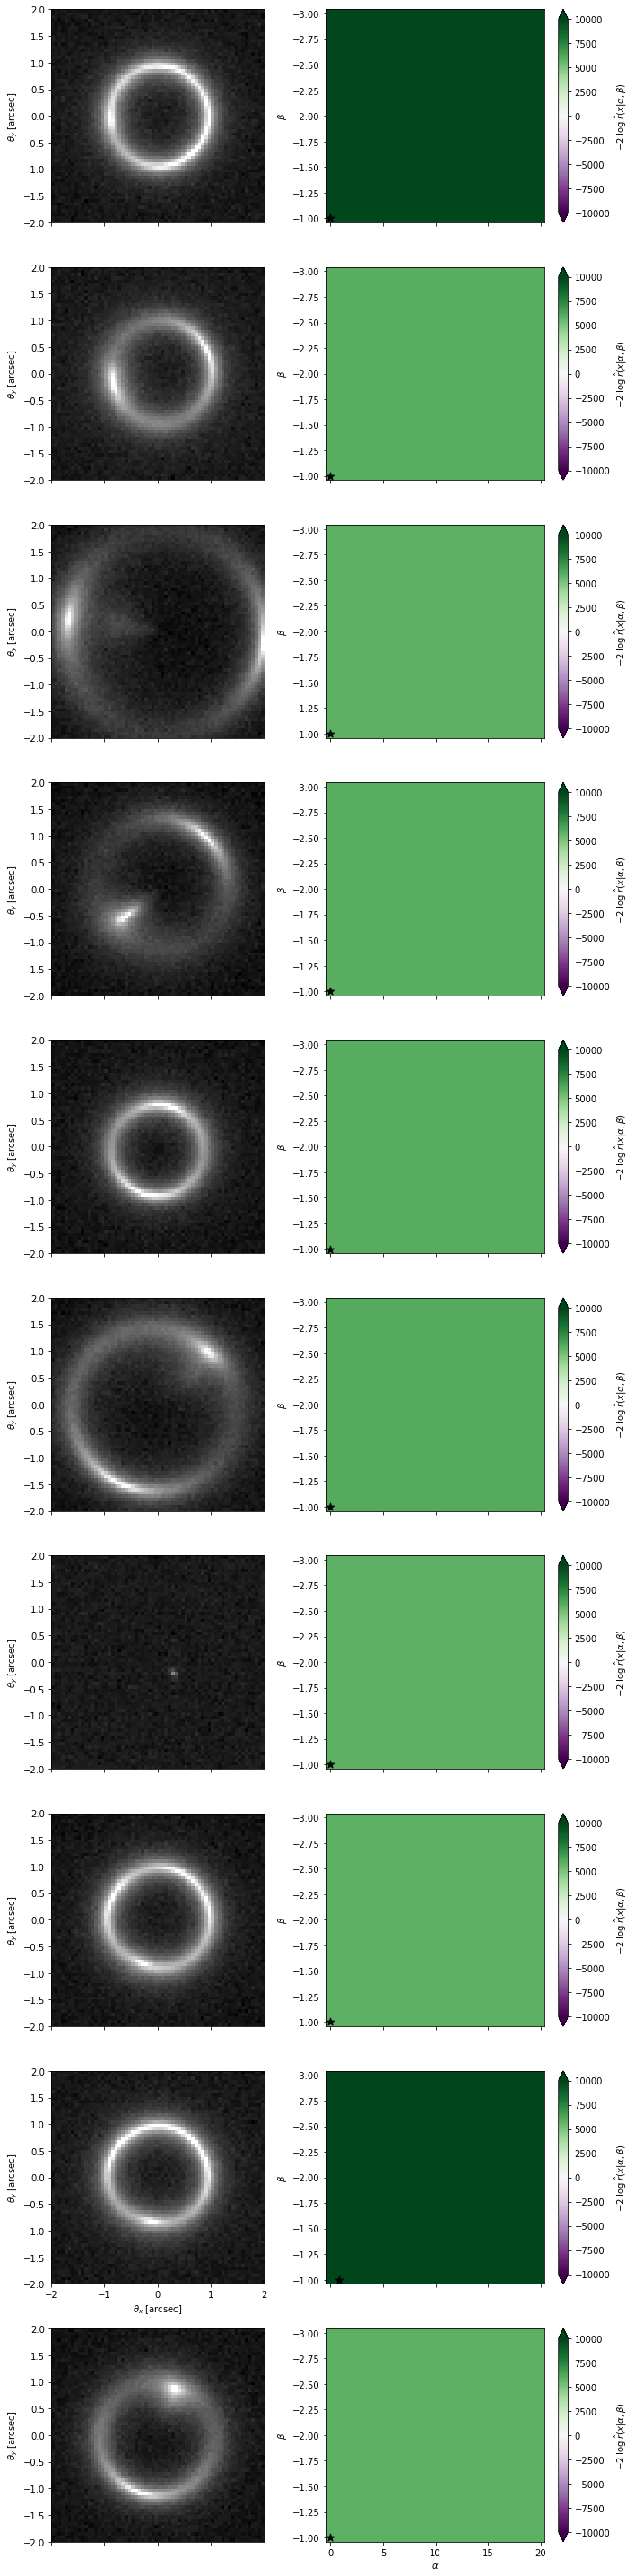

In [30]:
fig = plt.figure(figsize=(10, 4 * 10))

for i in [9,0,1,2,3,4,5,6,7,8]:
    
    # Plot image
    if i == 9:
        ax_left = plt.subplot(10, 2, i*2+1)
        ax = ax_left
    else:
        ax = plt.subplot(10, 2, i*2+1, sharex=ax_left)
    
    plt.imshow(
        np.log10(x_train[i]),
        vmax=3.5,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    if i == 8:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r"$\theta_y$ [arcsec]")
    
    
    
    # Plot estimated likelihood ratio for this image
    if i == 9:
        ax_right = plt.subplot(10, 2, i*2+2)
        ax = ax_right
    else:
        ax = plt.subplot(10, 2, i*2+2, sharex=ax_right)
        
    nllr_ = nllr[:, i]

    best_fit = theta_grid[np.argmin(nllr_)]
    cmin, cmax = -10000., 10000.

    bin_size = alpha_test[1] - alpha_test[0]
    alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
    bin_size = beta_test[1] - beta_test[0]
    beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        nllr_.reshape((grid_res, grid_res)),
        norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
        cmap='PRGn'
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

    if i == 9:
        plt.xlabel(r'$\alpha$')
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$')
    
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])

plt.tight_layout()
plt.savefig("../figures/carl_predictions.pdf")

## Evaluate expected LLR on grid

In [29]:
grid_res = 25

alpha_test = np.linspace(200., 800., grid_res)
beta_test = np.linspace(-1.3, -3.7, grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

In [ ]:
re = Estimator()
re.load("../data/models/carl")

nllr, _ = re.evaluate_ratio(x=x_test, theta0=theta_grid)
expected_nllr = -2. * np.sum(nllr, axis=1)

In [ ]:
fig = plt.figure(figsize=(5, 5))

best_fit = theta_grid[np.argmin(expected_nllr)]
cmin, cmax = -10., 10.

bin_size = alpha_test[1] - alpha_test[0]
alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
bin_size = beta_test[1] - beta_test[0]
beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

pcm = ax.pcolormesh(
    alpha_edges,
    beta_edges,
    expected_nllr.reshape((grid_res, grid_res)),
    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
    cmap='PRGn'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
cbar.set_label(r'$-2\; E[\log \;\hat{r}(x | \alpha, \beta)]$')

plt.tight_layout()
plt.savefig("../figures/alice_expected_llr.pdf")